In [39]:
import os
import numpy as np
import pandas as pd
import sys

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(os.path.dirname(os.getcwd()))
from tools.utils import encode_all_structures, Encoding

In [22]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)

# Loading Data

In [23]:
encoding = Encoding.COLUMN_MASS

df = pd.read_csv(os.path.join(DATA_DIR, "data.csv"), index_col=0, na_filter= False)
df = encode_all_structures(df, encoding)

In [27]:
cols_raw = list(df.columns)
cols_trash = ["structure", 'converged', "accuracy", "n_iterations", "delta_E", "fermi", "total_energy"]
cols_independent = ['time']
cols_drop = cols_trash + cols_independent

cols_dependent = cols_raw.copy()
for element in cols_drop:
    cols_dependent.remove(element)

In [28]:
X_raw = df[cols_dependent][df["converged"]]
y_raw = np.abs(df[cols_independent][df["converged"]]).squeeze()

In [29]:
X_raw.describe()

,ecutrho,k_density,ecutwfc,Lant,PTC1,PTC2,PTC3,PTC4,PTC5,PTC6,...,PTC9,PTC10,PTC11,PTC12,PTC13,PTC14,PTC15,PTC16,PTC17,PTC18
count,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,...,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.0
mean,243.637750,5.917276,55.419083,0.159506,0.049458,0.037120,0.028267,0.040596,0.028786,0.028198,...,0.067855,0.069810,0.066175,0.058606,0.056158,0.044858,0.061569,0.061289,0.021883,0.0
std,89.648334,2.822805,23.920181,0.290103,0.170662,0.131902,0.119200,0.153130,0.120652,0.126566,...,0.201673,0.210226,0.200467,0.184161,0.162863,0.151152,0.171189,0.159208,0.115921,0.0
min,100.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,180.000000,4.000000,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,260.000000,6.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,340.000000,8.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,380.000000,10.000000,100.000000,0.994010,0.924776,0.919574,0.789162,0.989072,0.885522,0.980984,...,0.983185,0.983118,0.942526,0.926130,0.967155,0.967587,0.967854,0.934031,0.987543,0.0


# Train-Test-Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    random_state=42
)

# Model definitions

### Linear Model with feature augmentation

In [9]:
linear_augmented_model = Pipeline([
    ('scaler_init', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('scaler_final', StandardScaler()),
    ('regressor', LinearRegression()),
])

### Random forest

In [10]:
rf_model = RandomForestRegressor(random_state=0)

### Gradient Boosting

In [11]:
gb_model = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05, random_state=0)

### XGBoost

In [12]:
xgb_model = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, random_state=0, tree_method="gpu_hist")

### Packing them together to reduce code size

In [13]:
models = {
    "Augmented Linear Regression": linear_augmented_model,
    "Random Forest": rf_model,
    #"Gradient Boosting": gb_model,
    #"XGBoost": xgb_model,
}

# Model training

In [14]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print("Done!\n")

Training Augmented Linear Regression...
Done!

Training Random Forest...
Done!



# Model evaluation

In [15]:
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    print(f"MAE:\ttrain:{mae_train:.4E}\ttest:{mae_test:.4E}")

    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

    print("Done!\n")

Evaluating Augmented Linear Regression...
MSE:	train:8.9464E+09	test:8.6012E+09
MAE:	train:4.5016E+04	test:4.4708E+04
MAPE:	train:6.9865E+00	test:6.9292E+00
Done!

Evaluating Random Forest...
MSE:	train:1.0341E+08	test:7.0825E+08
MAE:	train:2.3289E+03	test:6.2858E+03
MAPE:	train:2.5052E-02	test:6.8774E-02
Done!



# Visualization

Text(0.5, 0, 'ecutwfc')

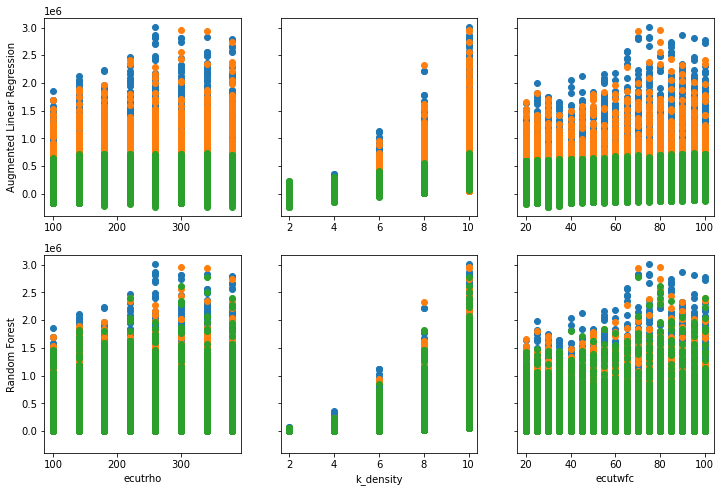

In [16]:
n_models = len(models)
fig, ax = plt.subplots(n_models,3,figsize=(12,4*n_models), sharey=True, squeeze=False)
for j, (name, model) in enumerate(models.items()):
    for i, col in enumerate(X_train.columns[:3]):
        ax[j,i].scatter(X_train[col], y_train)
        ax[j,i].scatter(X_test[col], y_test)
        ax[j,i].scatter(X_test[col], model.predict(X_test))
    ax[j,0].set_ylabel(name)
ax[-1,0].set_xlabel("ecutrho")
ax[-1,1].set_xlabel('k_density')
ax[-1,2].set_xlabel('ecutwfc')

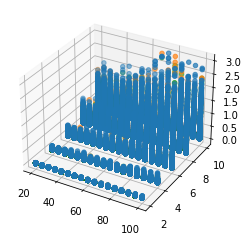

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['ecutwfc'], X_train['k_density'], y_train)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], y_test)
ax.scatter(X_test['ecutwfc'], X_test['k_density'], rf_model.predict(X_test))

In [18]:
labels = dict(x="ecutwfc", y="k_density")

# Hyperparameter optimization

In [31]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## Random Forest

In [9]:
rf_model = RandomForestRegressor(random_state=0, n_jobs=-1)

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

In [11]:
rf_random = RandomizedSearchCV(
    estimator = rf_model,
    param_distributions = random_grid,
    scoring='neg_mean_absolute_percentage_error',
    n_iter = 25,
    cv = 3,
    verbose=1,
    n_jobs=-1)

In [12]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [10, 120, 230, 340, 450,
                                                         560, 670, 780, 890,
                                                         1000]},
                   verbose=1)

In [13]:
rf_random.best_params_

{'n_estimators': 230, 'max_features': 'auto', 'max_depth': 40}

In [14]:
rf_best = RandomForestRegressor()
rf_best.set_params(**rf_random.best_params_)

RandomForestRegressor(max_depth=40, n_estimators=230)

In [15]:
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, n_estimators=230)

In [16]:
y_pred_train = rf_best.predict(X_train)
y_pred_test = rf_best.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f"MAE:\ttrain:{mae_train:.4E}\ttest:{mae_test:.4E}")

mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

print("Done!\n")

MSE:	train:1.0289E+08	test:7.0609E+08
MAE:	train:2.3547E+03	test:6.2717E+03
MAPE:	train:2.5641E-02	test:6.8861E-02
Done!



## XGBoost

In [32]:
xgb_model = xgb.XGBRegressor()
random_grid = {'n_estimators' : [10, 50, 100, 500, 1000],
               'booster': ['gbtree', 'gblinear', 'dart'],
               'learning_rate': [0.02, 0.05, 0.1, 0.2, 0.3],
               'min_split_loss': [0, 0.2, 0.4, 0.6, 0.8, 1.0],
               'max_depth' : [4, 6, 8, 10, 12],
               'lambda' : [0.5, 1, 1.5, 2.0],
               'alpha' : [0.0, 0.5, 1.0, 1.5]
              }

In [33]:
xgb_random = RandomizedSearchCV(estimator=xgb_model,
                                param_distributions=random_grid,
                                scoring='neg_mean_absolute_percentage_error',
                                n_iter=25,
                                cv=3,
                                verbose=2,
                               )

In [34]:
xgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END alpha=1.5, booster=dart, lambda=1.5, learning_rate=0.05, max_depth=8, min_split_loss=0.2, n_estimators=50; total time=  30.9s
[CV] END alpha=1.5, booster=dart, lambda=1.5, learning_rate=0.05, max_depth=8, min_split_loss=0.2, n_estimators=50; total time=  34.7s
[CV] END alpha=1.5, booster=dart, lambda=1.5, learning_rate=0.05, max_depth=8, min_split_loss=0.2, n_estimators=50; total time=  30.5s
[14:38:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_depth", "min_split_loss" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END alpha=1.0, booster=gblinear, lambda=0.5, learning_rate=0.1, max_depth=4, min_split_loss=0.2, n_estimators=100; tota

[CV] END alpha=1.5, booster=gblinear, lambda=2.0, learning_rate=0.02, max_depth=6, min_split_loss=0.2, n_estimators=1000; total time=   8.5s
[14:47:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_depth", "min_split_loss" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END alpha=1.5, booster=gblinear, lambda=2.0, learning_rate=0.02, max_depth=6, min_split_loss=0.2, n_estimators=1000; total time=   8.6s
[CV] END alpha=0.5, booster=dart, lambda=1.5, learning_rate=0.1, max_depth=4, min_split_loss=1.0, n_estimators=50; total time=  10.6s
[CV] END alpha=0.5, booster=dart, lambda=1.5, learning_rate=0.1, max_depth=4, min_split_loss=1.0, n_estimators=50; total time=  11.0s
[CV] END alpha=0.5, booster=dart, lambda

[15:52:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "max_depth", "min_split_loss" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END alpha=1.0, booster=gblinear, lambda=1.5, learning_rate=0.2, max_depth=4, min_split_loss=0.4, n_estimators=10; total time=   0.2s
[CV] END alpha=0.5, booster=dart, lambda=2.0, learning_rate=0.05, max_depth=6, min_split_loss=0, n_estimators=10; total time=   1.4s
[CV] END alpha=0.5, booster=dart, lambda=2.0, learning_rate=0.05, max_depth=6, min_split_loss=0, n_estimators=10; total time=   1.4s
[CV] END alpha=0.5, booster=dart, lambda=2.0, learning_rate=0.05, max_depth=6, min_split_loss=0, n_estimators=10; total time=   1.9s
[CV] END alpha=1.5, booster=gbtree, lambda=1, learnin

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=25,
                   param_distribut

In [35]:
xgb_random.best_params_

{'n_estimators': 500,
 'min_split_loss': 0.2,
 'max_depth': 12,
 'learning_rate': 0.1,
 'lambda': 1,
 'booster': 'gbtree',
 'alpha': 0.5}

In [36]:
xgb_best = xgb.XGBRegressor()
xgb_best.set_params(**xgb_random.best_params_)
xgb_best.fit(X_train, y_train)


XGBRegressor(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.200000003, gpu_id=-1, importance_type=None,
             interaction_constraints='', lambda=1, learning_rate=0.1,
             max_delta_step=0, max_depth=12, min_child_weight=1,
             min_split_loss=0.2, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1, ...)

In [37]:
y_pred_train = xgb_best.predict(X_train)
y_pred_test = xgb_best.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f"MAE:\ttrain:{mae_train:.4E}\ttest:{mae_test:.4E}")

mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

print("Done!\n")

MSE:	train:8.5976E+07	test:6.9596E+08
MAE:	train:3.1102E+03	test:6.6150E+03
MAPE:	train:9.4001E-02	test:1.2534E-01
Done!



## LGBM

In [66]:
lgbm_model = lgb.LGBMRegressor()
random_grid = {'n_estimators' : [10, 50, 100, 500, 1000],
               'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
               'learning_rate': [0.02, 0.05, 0.1, 0.2, 0.3],
               'num_leaves' : [5, 10, 25, 50, 100],
               'max_depth' : [4, 6, 8, 10, 12],
               'reg_lambda' : [0.0, 0.1, 0.5, 1.0, 1.5],
               'reg_alpha' : [0.0, 0.1, 0.5, 1.0, 1.5]
              }

In [67]:
lgbm_random = RandomizedSearchCV(estimator=lgbm_model,
                                param_distributions=random_grid,
                                scoring='neg_mean_absolute_percentage_error',
                                n_iter=25,
                                cv=3,
                                verbose=2,
                               )

In [68]:
lgbm_random.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END boosting_type=gbdt, learning_rate=0.05, max_depth=4, n_estimators=1000, num_leaves=5, reg_alpha=1.0, reg_lambda=1.0; total time=   4.0s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_depth=4, n_estimators=1000, num_leaves=5, reg_alpha=1.0, reg_lambda=1.0; total time=   7.7s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_depth=4, n_estimators=1000, num_leaves=5, reg_alpha=1.0, reg_lambda=1.0; total time=  10.3s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=5, reg_alpha=0.5, reg_lambda=1.0; total time=   0.7s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=5, reg_alpha=0.5, reg_lambda=1.0; total time=   0.6s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_depth=4, n_estimators=50, num_leaves=5, reg_alpha=0.5, reg_lambda=1.0; total time=   1.0s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.02, max_depth=10, n_estimators=50, num_leaves=5, reg_alpha=1.5, reg_lambda=1.0; total time=   0.3s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.02, max_depth=10, n_estimators=50, num_leaves=5, reg_alpha=1.5, reg_lambda=1.0; total time=   0.2s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.02, max_depth=10, n_estimators=50, num_leaves=5, reg_alpha=1.5, reg_lambda=1.0; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=12, n_estimators=10, num_leaves=5, reg_alpha=0.1, reg_lambda=1.0; total time=   0.4s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=12, n_estimators=10, num_leaves=5, reg_alpha=0.1, reg_lambda=1.0; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.05, max_depth=12, n_estimators=10, num_leaves=5, reg_alpha=0.1, reg_lambda=1.0; total time=   1.2s
[CV] END boosting_type=goss, learning_rate=0.2, max_depth=6, n_estimators=10, num_leaves=25, reg_alpha=1.0, reg_lambda=0.1; total time=   1.0s
[CV] END boosting_type=goss, learning_rate=0.2, max_depth=6, n_estimators=10, num_leaves=25, reg_alpha=1.0, reg_lambda=0.1; total time=   0.6s
[CV] END boosting_type=goss, learning_rate=0.2, max_depth=6, n_estimators=10, num_leaves=25, reg_alpha=1.0, reg_lambda=0.1; total time=   0.

/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=10, reg_alpha=0.5, reg_lambda=0.5; total time=   0.3s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=10, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.1, max_depth=10, n_estimators=10, num_leaves=10, reg_alpha=0.5, reg_lambda=0.5; total time=   0.4s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5; total time=   0.7s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5; total time=   1.0s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=50, reg_alpha=0.5, reg_lambda=0.5; total time=   0.8s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.1, max_depth=12, n_estimators=50, num_leaves=10, reg_alpha=0.0, reg_lambda=1.0; total time=   0.3s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.1, max_depth=12, n_estimators=50, num_leaves=10, reg_alpha=0.0, reg_lambda=1.0; total time=   0.2s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.1, max_depth=12, n_estimators=50, num_leaves=10, reg_alpha=0.0, reg_lambda=1.0; total time=   0.3s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=12, n_estimators=10, num_leaves=10, reg_alpha=0.1, reg_lambda=0.0; total time=   1.7s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=12, n_estimators=10, num_leaves=10, reg_alpha=0.1, reg_lambda=0.0; total time=   0.7s
[CV] END boosting_type=dart, learning_rate=0.1, max_depth=12, n_estimators=10, num_leaves=10, reg_alpha=0.1, reg_lambda=0.0; total time=   0.5s
[CV] END boosting_type=gbdt, learning_rate=0.2, max_depth=8, n_estimators=1000, num_leaves=5, reg_alpha=1.5, reg_lambda=0.1; total time=   4.2s
[CV] END boosting_type=gbdt, learning_rate=0.2, max_depth=8, n_estimators=1000, num_leaves=5, reg_alpha=1.5, reg_lambda=0.1; total time=   7.1s
[CV] END boosting_type=gbdt, learning_rate=0.2, max_depth=8, n_estimators=1000, num_leaves=5, reg_alpha=1.5, reg_lambda=0.1; total time=  

/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.3, max_depth=12, n_estimators=500, num_leaves=5, reg_alpha=0.5, reg_lambda=1.5; total time=   0.2s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.3, max_depth=12, n_estimators=500, num_leaves=5, reg_alpha=0.5, reg_lambda=1.5; total time=   0.4s
[CV] END boosting_type=goss, learning_rate=0.02, max_depth=12, n_estimators=10, num_leaves=100, reg_alpha=0.5, reg_lambda=1.5; total time=   1.5s
[CV] END boosting_type=goss, learning_rate=0.02, max_depth=12, n_estimators=10, num_leaves=100, reg_alpha=0.5, reg_lambda=1.5; total time=   0.9s
[CV] END boosting_type=goss, learning_rate=0.02, max_depth=12, n_estimators=10, num_leaves=100, reg_alpha=0.5, reg_lambda=1.5; total time=   0.6s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=100, reg_alpha=1.0, reg_lambda=1.5; total time=   9.8s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=100, reg_alpha=1.0, reg_lambda=1.5; total time=  12.6s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_depth=8, n_estimators=500, num_leaves=100, reg_alpha=1.0, reg_lambda=1.5; tota

/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.02, max_depth=8, n_estimators=10, num_leaves=10, reg_alpha=1.0, reg_lambda=0.5; total time=   0.2s
[CV] END boosting_type=rf, learning_rate=0.02, max_depth=8, n_estimators=10, num_leaves=10, reg_alpha=1.0, reg_lambda=0.5; total time=   0.2s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=dart, learning_rate=0.02, max_depth=6, n_estimators=1000, num_leaves=100, reg_alpha=1.0, reg_lambda=0.0; total time= 4.8min
[CV] END boosting_type=dart, learning_rate=0.02, max_depth=6, n_estimators=1000, num_leaves=100, reg_alpha=1.0, reg_lambda=0.0; total time= 5.6min
[CV] END boosting_type=dart, learning_rate=0.02, max_depth=6, n_estimators=1000, num_leaves=100, reg_alpha=1.0, reg_lambda=0.0; total time= 4.1min
[CV] END boosting_type=gbdt, learning_rate=0.3, max_depth=10, n_estimators=10, num_leaves=10, reg_alpha=1.5, reg_lambda=1.0; total time=   0.3s
[CV] END boosting_type=gbdt, learning_rate=0.3, max_depth=10, n_estimators=10, num_leaves=10, reg_alpha=1.5, reg_lambda=1.0; total time=   0.3s
[CV] END boosting_type=gbdt, learning_rate=0.3, max_depth=10, n_estimators=10, num_leaves=10, reg_alpha=1.5, reg_lambda=1.0; total time=   0.3s
[CV] END boosting_type=rf, learning_rate=0.3, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=1.5, reg_lambda=0.5; tota

/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.3, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=1.5, reg_lambda=0.5; total time=   0.2s


/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basi

[CV] END boosting_type=rf, learning_rate=0.3, max_depth=10, n_estimators=10, num_leaves=25, reg_alpha=1.5, reg_lambda=0.5; total time=   0.2s
[CV] END boosting_type=dart, learning_rate=0.02, max_depth=8, n_estimators=50, num_leaves=10, reg_alpha=0.5, reg_lambda=0.1; total time=   0.8s
[CV] END boosting_type=dart, learning_rate=0.02, max_depth=8, n_estimators=50, num_leaves=10, reg_alpha=0.5, reg_lambda=0.1; total time=   1.1s
[CV] END boosting_type=dart, learning_rate=0.02, max_depth=8, n_estimators=50, num_leaves=10, reg_alpha=0.5, reg_lambda=0.1; total time=   0.7s
[CV] END boosting_type=goss, learning_rate=0.3, max_depth=6, n_estimators=100, num_leaves=10, reg_alpha=1.5, reg_lambda=1.5; total time=   1.3s
[CV] END boosting_type=goss, learning_rate=0.3, max_depth=6, n_estimators=100, num_leaves=10, reg_alpha=1.5, reg_lambda=1.5; total time=   1.3s
[CV] END boosting_type=goss, learning_rate=0.3, max_depth=6, n_estimators=100, num_leaves=10, reg_alpha=1.5, reg_lambda=1.5; total time=  

/Users/philipp/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [ -3.16778351  -2.89849954          nan -24.34696338  -5.37942258
 -28.36134054 -15.117659    -0.67815115  -2.67019896          nan
 -21.01810122          nan -16.92310896  -2.34972927          nan
 -27.8855879   -0.48837326  -2.60408309          nan  -0.59628614
  -3.89626296          nan -16.74445432  -2.64722741  -1.90404149]
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(), n_iter=25,
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss', 'rf'],
                                        'learning_rate': [0.02, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'max_depth': [4, 6, 8, 10, 12],
                                        'n_estimators': [10, 50, 100, 500,
                                                         1000],
                                        'num_leaves': [5, 10, 25, 50, 100],
                                        'reg_alpha': [0.0, 0.1, 0.5, 1.0, 1.5],
                                        'reg_lambda': [0.0, 0.1, 0.5, 1.0,
                                                       1.5]},
                   scoring='neg_mean_absolute_percentage_error', verbose=2)

In [69]:
lgbm_random.best_params_

{'reg_lambda': 1.5,
 'reg_alpha': 1.0,
 'num_leaves': 100,
 'n_estimators': 500,
 'max_depth': 8,
 'learning_rate': 0.1,
 'boosting_type': 'gbdt'}

In [70]:
lgbm_best = lgb.LGBMRegressor()
lgbm_best.set_params(**lgbm_random.best_params_)
lgbm_best.fit(X_train, y_train)

LGBMRegressor(max_depth=8, n_estimators=500, num_leaves=100, reg_alpha=1.0,
              reg_lambda=1.5)

In [71]:
y_pred_train = lgbm_best.predict(X_train)
y_pred_test = lgbm_best.predict(X_test)

mse_test = mean_squared_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
print(f"MSE:\ttrain:{mse_train:.4E}\ttest:{mse_test:.4E}")

mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f"MAE:\ttrain:{mae_train:.4E}\ttest:{mae_test:.4E}")

mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
print(f"MAPE:\ttrain:{mape_train:.4E}\ttest:{mape_test:.4E}")

print("Done!\n")

MSE:	train:6.8315E+08	test:8.7447E+08
MAE:	train:8.5162E+03	test:9.2387E+03
MAPE:	train:5.0539E-01	test:5.0740E-01
Done!

